# classification es el notebook oficial de clasificación

### - Limpiamos los datos según conclusiones del notebook main
### - Probaremos distintos algorítmos de clasificación y compararemos los resultados
### - Utilizamos el dataset de train ya recortado por la cátedra

---





## ACA TODOS LOS IMPORTS DEL NOTEBOOK

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, validation_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_curve

from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier

from scripts.auc_curves_data import auc_curves_data
from scripts.auc_curves_plot import auc_curves_plot
from scripts.roc_pr_perceptron import roc_pr_percetron

2021-11-15 20:11:46.598749: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-15 20:11:46.598765: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## LECTURA Y LIMPIEZA DEL DATASET

In [2]:
#datos de entrenamiento (80% del dataset original)
df_orig = pd.read_csv(r"DS_G3_HeartFailure_FULL_train.csv",index_col=0)  
df_orig.shape

(239, 13)

In [3]:
df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
# NOS QUEDAMOS CON AGE, CREATININE_PHOSPHOKINASE, EJECTION_FRACTION, PLATELETS, SERUM_CREATININE, SERUM_SODIUM Y DEATH_EVENT

feat_train, targ_train = df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"]
print(feat_train.shape)
print(targ_train.shape)
# df_cleaned.head()

(239, 6)
(239,)


## Transformaciones necesarias al df

In [4]:
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)

print(np.sum(targ_train==0))
print(np.sum(targ_train==1))

#APLICAMOS SMOTE PARA AUMENTAR LA CANTIDAD DE SAMPLES Y BALANCEAR EL TARGET
feat_train, targ_train = SMOTE(random_state=420).fit_resample(feat_train, targ_train)
print(feat_train.shape)

print(np.sum(targ_train==0))
print(np.sum(targ_train==1))

163
76
(326, 6)
163
163


## ACA TENEMOS EL DATASET RECORTADO Y STANDARIZADO 

In [5]:
# Queremos pocos FN, es decir pacientes q decimos q NO tienen riesgo pero SI.
score_metric = "recall" 

---

## ALGUNAS FUNCIONES UTILES PARA GRAFICAR

In [6]:
def train_val_curve (model,param,param_range): 
    train__scores, val__scores = validation_curve(model,feat_train,targ_train,param_name=param,param_range=param_range,scoring=score_metric,cv=20)
    train__mean = np.mean(train__scores,axis=1)
    val__mean = np.mean(val__scores,axis=1)
    
    plt.figure(figsize=(20,10))
    plt.subplot(2,2,2)
    plt.plot(param_range,train__mean,color='blue',marker='o',markersize=5,label='training recall')
    plt.xscale("log")
    plt.plot(param_range,val__mean,color='green',marker='x',markersize=5,label='validation recall') 
    plt.xlabel(param)
    plt.ylabel(score_metric)
    plt.legend(loc='upper left')

In [7]:
def plt_eb (model,rmax):
    means,errors = [],[]
    
    for j in range(2,rmax):
        scorings = cross_val_score(model, feat_train, targ_train,cv=j, scoring=score_metric)
        means.append(scorings.mean())
        errors.append(scorings.std())

    plt.figure(figsize=(12,6))
    plt.xlabel("Cantidad de Folds en CV")
    plt.ylabel("Recall Score")
    plt.title("Mean: {:.3f}+/-{:.3f}".format(np.mean(means),np.mean(errors)))
    plt.ylim((0,1.1))
    plt.errorbar(x=range(2,rmax),y=means,yerr=errors,fmt="-o")

In [8]:
def model_setup (model):
    
    model.fit(feat_train,targ_train)

    scoring = cross_val_score(model, feat_train, targ_train,cv=10, scoring=score_metric)
    print("Cross Validation Score: {:.3f} +/- {:.3f}".format(scoring.mean(),scoring.std()))

    predicted = cross_val_predict(model,feat_train,targ_train,cv=3)
    print(classification_report(targ_train, predicted))
    
    cm = confusion_matrix(targ_train, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()   

---
---
---

### Perpectron Nº1

Cross Validation Score: 0.542 +/- 0.242
              precision    recall  f1-score   support

           0       0.74      0.57      0.65       163
           1       0.65      0.80      0.72       163

    accuracy                           0.69       326
   macro avg       0.70      0.69      0.68       326
weighted avg       0.70      0.69      0.68       326

[-1.] [[ 0.69317218  3.78883436 -2.64658525  1.55242184  0.82901539 -1.28516939]]


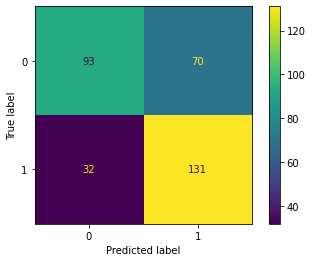

In [9]:
percep1 = Perceptron(fit_intercept=True, max_iter=40000)  
model_setup(percep1)
print(percep1.intercept_,percep1.coef_)

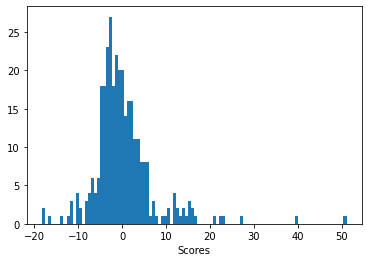

In [10]:
y_scores = cross_val_predict(percep1, feat_train, targ_train, cv=10, method="decision_function")

A = plt.hist(y_scores,100)
plt.xlabel('Scores')
plt.show()

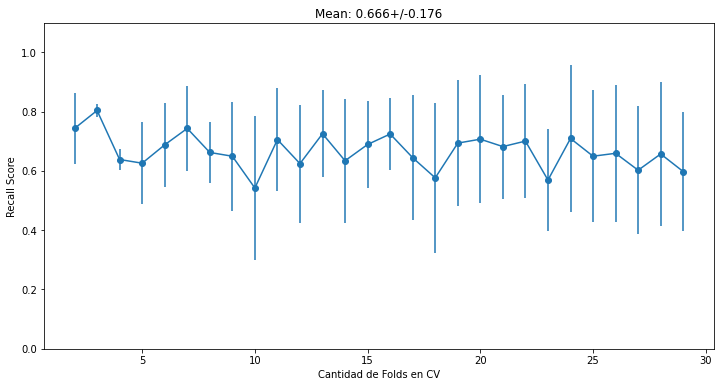

In [11]:
plt_eb(percep1,30)

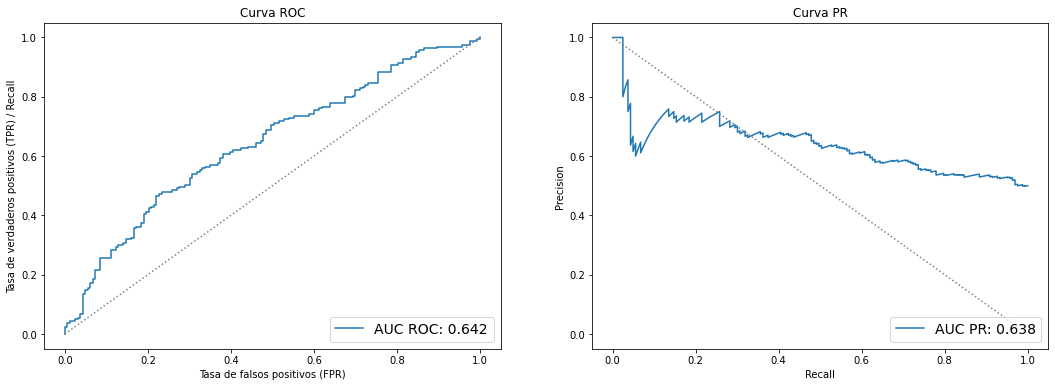

In [12]:
auc_data_percep1 = roc_pr_percetron(targ_train, y_scores,'Percep1') 

In [13]:
# #Genero las mismas curvas pero con otras funciones.
# # Observación: dan diferentes, eso es por la selección de cv=10, si coloco cv=5, dan iguales

# from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
# plot_precision_recall_curve(percep1, feat_train, targ_train)
# plot_roc_curve(percep1, feat_train, targ_train)

### Perpectron Nº2

Cross Validation Score: 0.773 +/- 0.110
              precision    recall  f1-score   support

           0       0.68      0.63      0.65       163
           1       0.65      0.70      0.67       163

    accuracy                           0.66       326
   macro avg       0.66      0.66      0.66       326
weighted avg       0.66      0.66      0.66       326



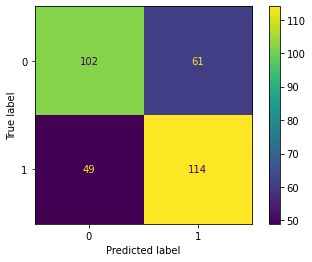

In [14]:
percep2 = Perceptron(max_iter=40000,penalty="l2",random_state=420,alpha=0.0012689610031679235,eta0=0.041753189365604) 
model_setup(percep2)

In [15]:
hyperparam = {"eta0":np.logspace(-2,1,30),"alpha":np.logspace(-7,0,30)}
per_model = Perceptron(fit_intercept=True, max_iter=40000,penalty="l2",random_state=420,alpha=5e-5,eta0=0.05)
per_grilla = GridSearchCV(per_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
per_grilla.fit(feat_train,targ_train)
print(per_grilla.best_params_)
svm_model = per_grilla.best_estimator_

{'alpha': 0.0012689610031679235, 'eta0': 0.041753189365604}


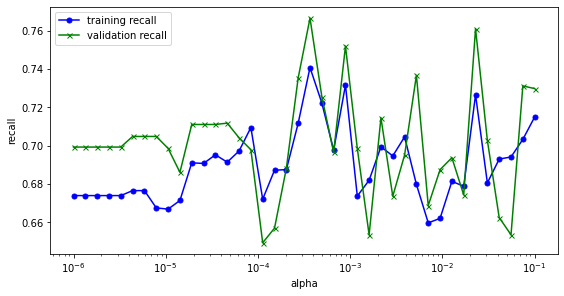

In [16]:
train_val_curve(percep2,"alpha",np.logspace(-6,-1,40))

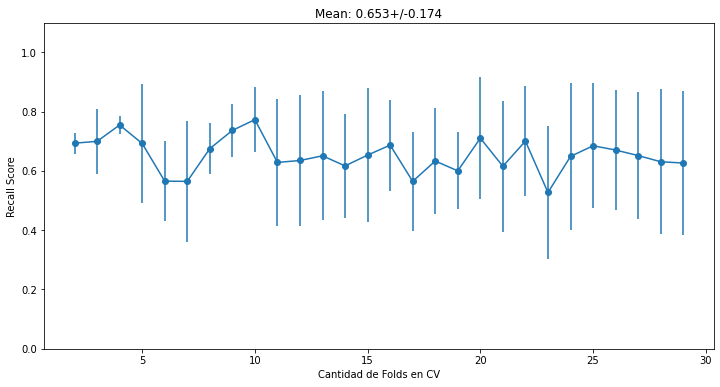

In [17]:
plt_eb(percep2,30)

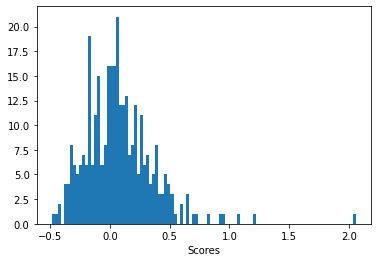

In [18]:
y_scores = cross_val_predict(percep2, feat_train, targ_train, cv=10, method="decision_function")

A = plt.hist(y_scores,100)
plt.xlabel('Scores')
plt.show()

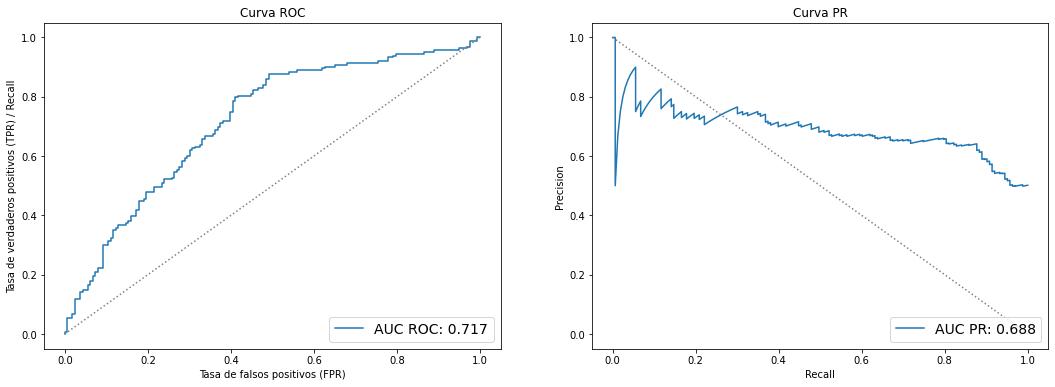

In [19]:
auc_data_percep2 = roc_pr_percetron(targ_train, y_scores,'Percep2')

### Logistic Regresion

Cross Validation Score: 0.731 +/- 0.107
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       163
           1       0.72      0.72      0.72       163

    accuracy                           0.72       326
   macro avg       0.72      0.72      0.72       326
weighted avg       0.72      0.72      0.72       326



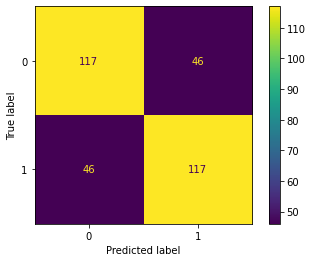

In [20]:
lr_model = LogisticRegression(dual=False, max_iter=40000,C=2.9470517025518097)  
model_setup(lr_model)

In [21]:
hyperparam = {"C":np.logspace(-1,3,50)}
lr_model = LogisticRegression(dual=False, max_iter=40000,C=2)
lr_grilla = GridSearchCV(lr_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
lr_grilla.fit(feat_train,targ_train)
print(lr_grilla.best_params_)
lr_model = lr_grilla.best_estimator_

{'C': 2.9470517025518097}


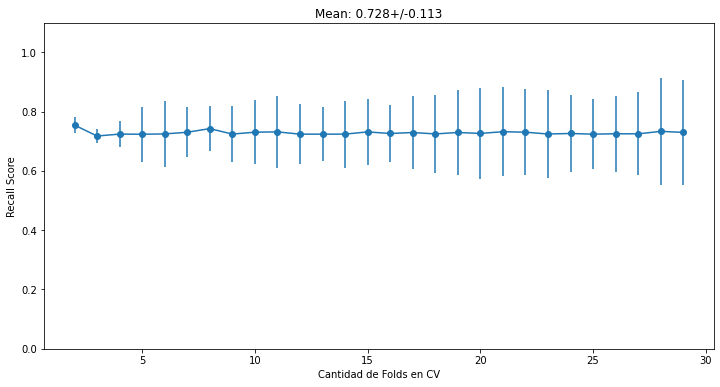

In [22]:
plt_eb(lr_model,30)

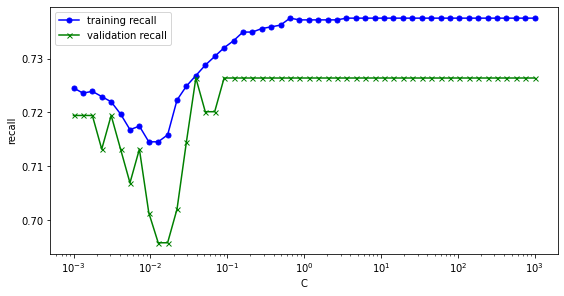

In [23]:
train_val_curve(lr_model,"C",np.logspace(-3,3,50))

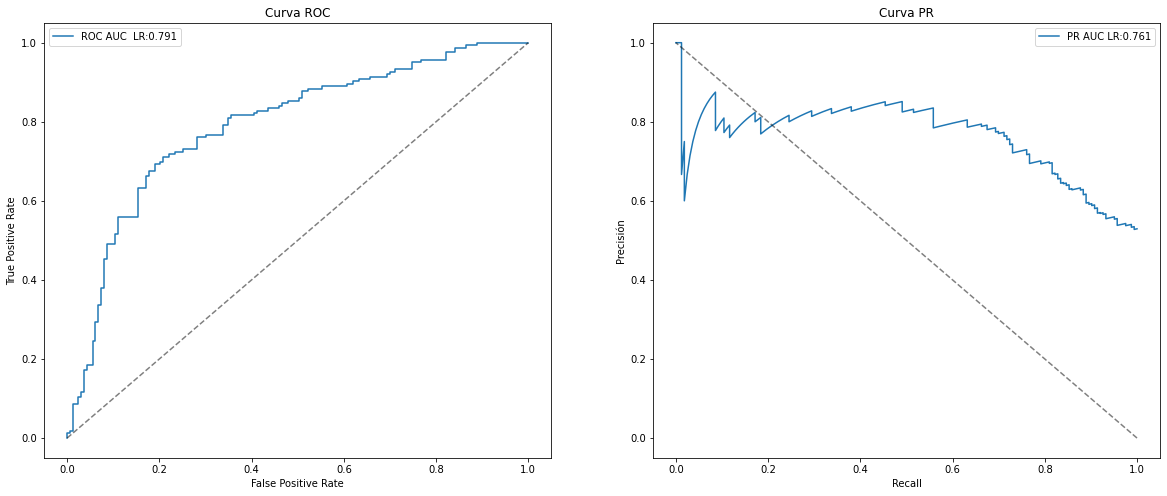

In [24]:
auc_data_lr = []
(ROC_fpr, ROC_tpr, PR_recalls, PR_precisions) = auc_curves_data(lr_model,feat_train,targ_train)
auc_data_lr.append((ROC_fpr, ROC_tpr, PR_recalls, PR_precisions, 'LR'))
auc_curves_plot(auc_data_lr)

---

### Support Vector Classifier

Cross Validation Score: 0.895 +/- 0.063
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       163
           1       0.71      0.83      0.76       163

    accuracy                           0.74       326
   macro avg       0.75      0.74      0.74       326
weighted avg       0.75      0.74      0.74       326



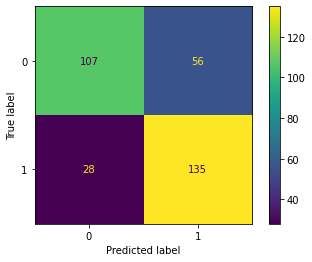

In [25]:
svc_model = SVC(probability=True,gamma=1.1721022975334805,C=0.1487352107293511)  
model_setup(svc_model)

In [26]:
hyperparam = {"C":np.logspace(-2,0,30),"gamma":np.logspace(-2,2,30)}
svm_model = SVC(break_ties=True,probability=True)
svm_grilla = GridSearchCV(svm_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
svm_grilla.fit(feat_train,targ_train)
print(svm_grilla.best_params_)
svm_model = svm_grilla.best_estimator_

{'C': 0.1487352107293511, 'gamma': 1.1721022975334805}


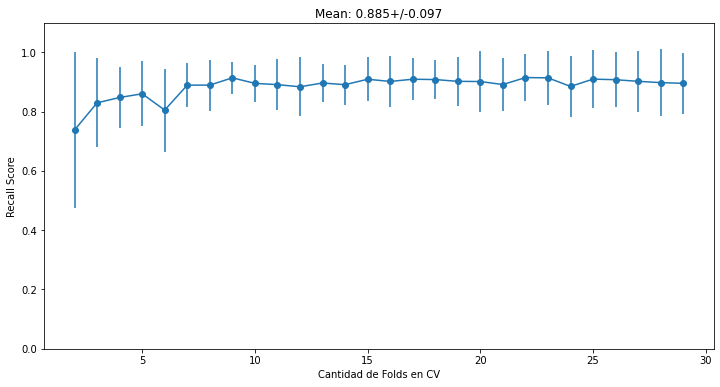

In [27]:
plt_eb(svc_model,30)

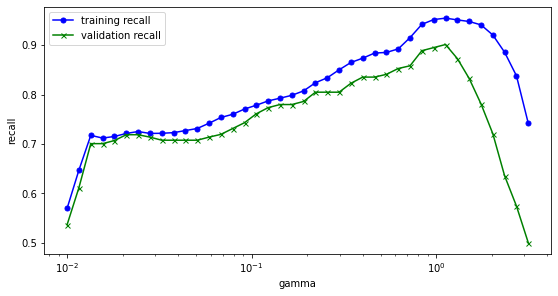

In [28]:
train_val_curve(svc_model,"gamma",np.logspace(-2,0.5,40))

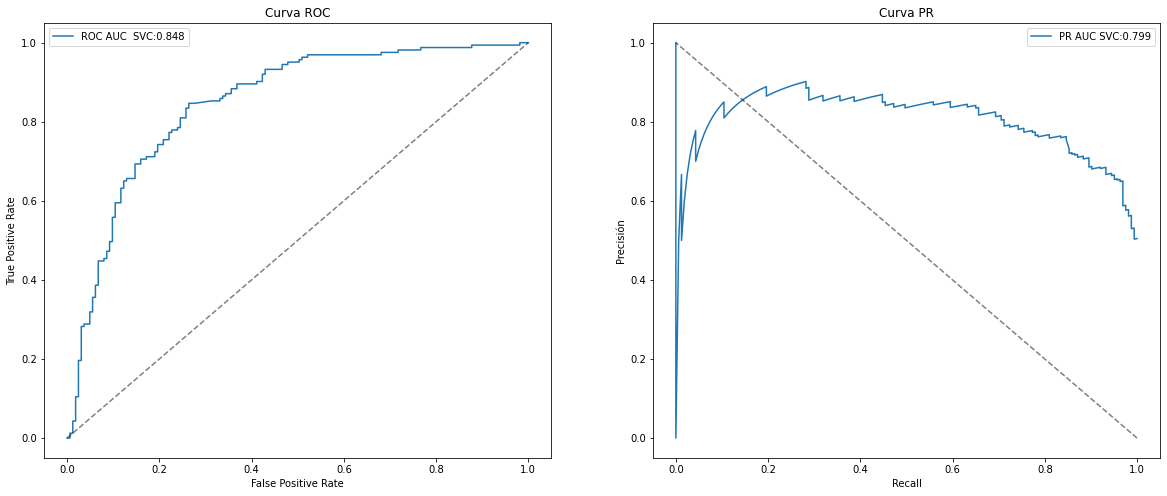

In [29]:
auc_data_svc = []
(ROC_fpr, ROC_tpr, PR_recalls, PR_precisions) = auc_curves_data(svc_model,feat_train,targ_train)
auc_data_svc.append((ROC_fpr, ROC_tpr, PR_recalls, PR_precisions, 'SVC'))
auc_curves_plot(auc_data_svc)

---

### Random Forest

Cross Validation Score: 0.849 +/- 0.121
              precision    recall  f1-score   support

           0       0.84      0.77      0.81       163
           1       0.79      0.85      0.82       163

    accuracy                           0.81       326
   macro avg       0.81      0.81      0.81       326
weighted avg       0.81      0.81      0.81       326



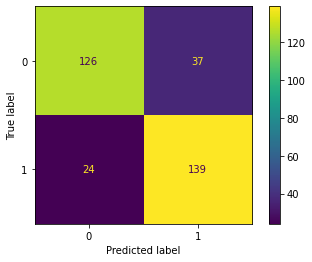

In [30]:
rf_model = RandomForestClassifier(n_estimators=50)  
model_setup(rf_model)

In [31]:
hyperparam = {"n_estimators":[20,50,100,200,400],"max_depth":[5,6,7,8,9,None],"min_samples_split":[2,20,30,40]}
rf_model = RandomForestClassifier(min_impurity_decrease=2e-4)
rf_grilla = GridSearchCV(rf_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
rf_grilla.fit(feat_train,targ_train)
rf_model = rf_grilla.best_estimator_
print(rf_grilla.best_params_)

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 400}


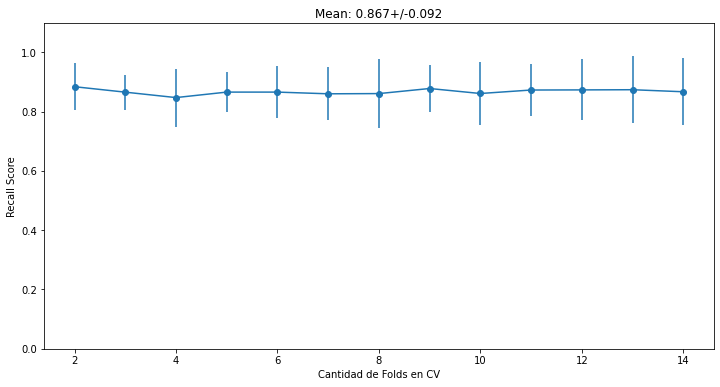

In [32]:
plt_eb(rf_model,15)

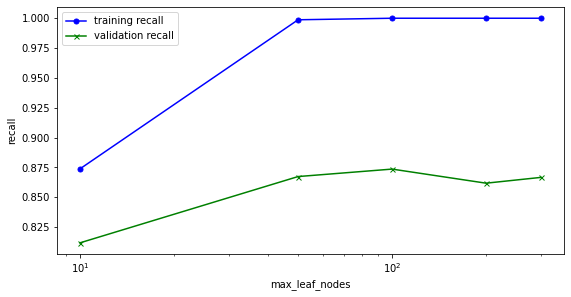

In [33]:
train_val_curve(rf_model,"max_leaf_nodes",[10,50,100,200,300])

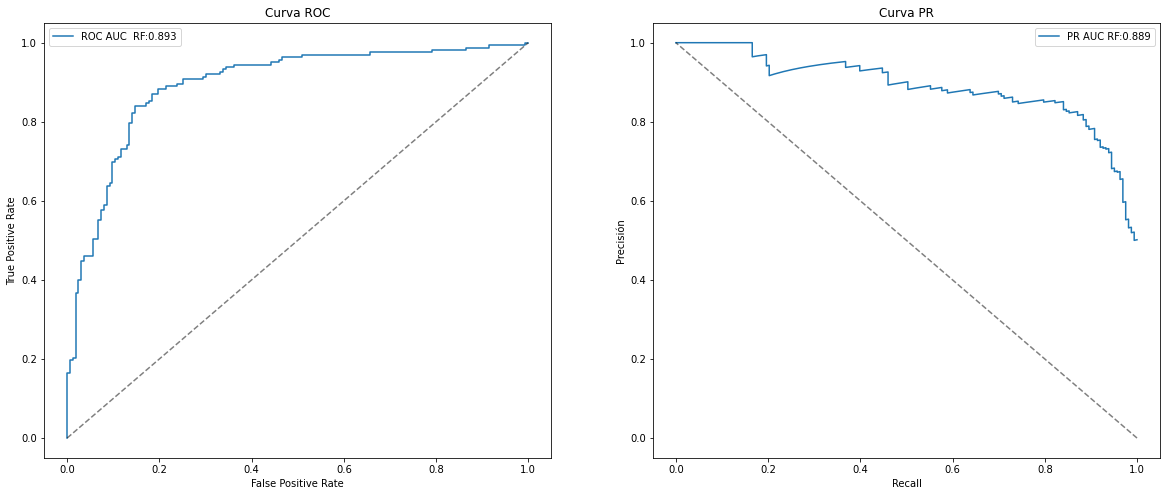

In [34]:
auc_data_rf = []
(ROC_fpr, ROC_tpr, PR_recalls, PR_precisions) = auc_curves_data(rf_model,feat_train,targ_train)
auc_data_rf.append((ROC_fpr, ROC_tpr, PR_recalls, PR_precisions, 'RF'))
auc_curves_plot(auc_data_rf)

---

### ADA Boosting

Cross Validation Score: 0.811 +/- 0.086
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       163
           1       0.71      0.75      0.73       163

    accuracy                           0.72       326
   macro avg       0.72      0.72      0.72       326
weighted avg       0.72      0.72      0.72       326



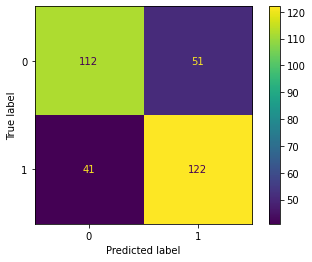

In [35]:
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),learning_rate=2e-2)  
model_setup(ada_model)

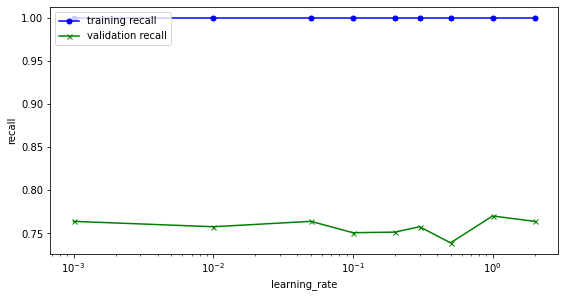

In [36]:
train_val_curve(ada_model,"learning_rate",[0.001,0.01,0.05,0.1,0.2,0.3,0.5,1,2])  #np.logspace(-5,-0,30)

(array([163.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 163.]),
 array([2.22044605e-16, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

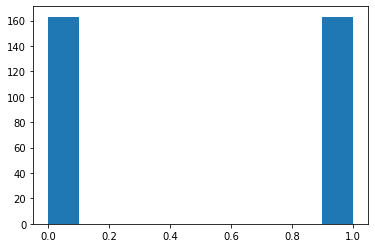

In [37]:
plt.hist(ada_model.predict_proba(feat_train)[:,1])

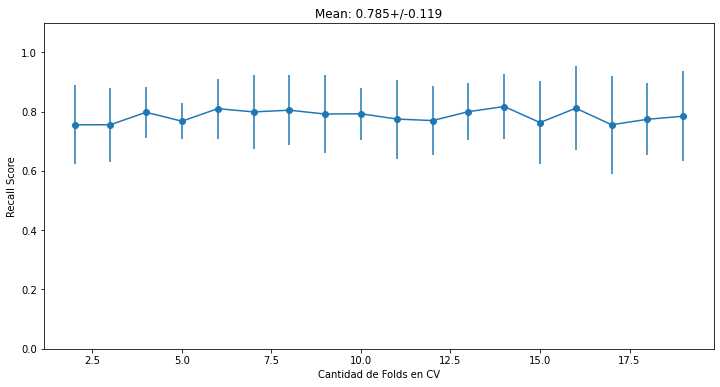

In [38]:
plt_eb(ada_model,20)

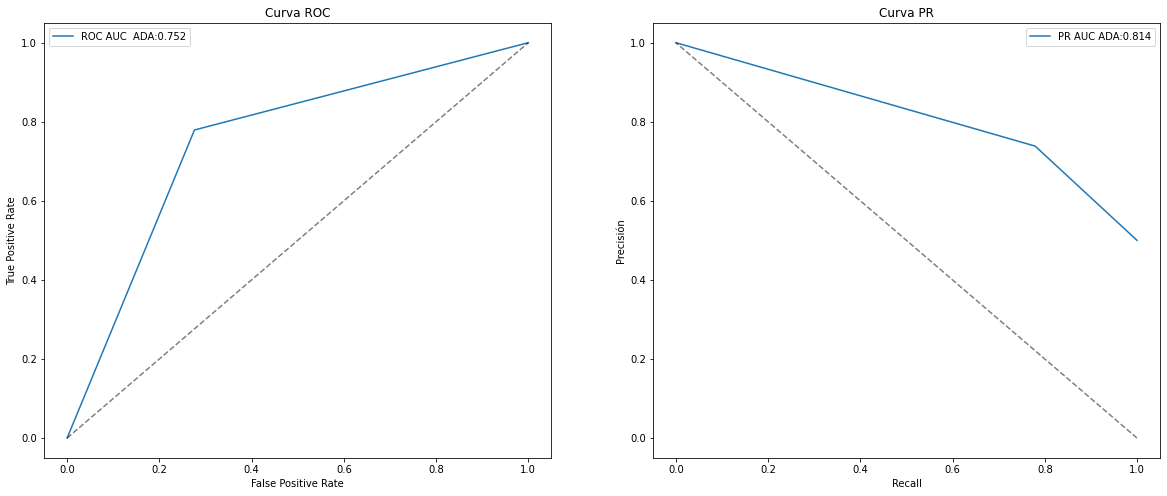

In [39]:
auc_data_ada = []
(ROC_fpr, ROC_tpr, PR_recalls, PR_precisions) = auc_curves_data(ada_model,feat_train,targ_train)
auc_data_ada.append((ROC_fpr, ROC_tpr, PR_recalls, PR_precisions, 'ADA'))
auc_curves_plot(auc_data_ada)


---


### Gradient Boosting (XGBC)

In [40]:
# NECESARIO CREAR DATOS DE VALIDACION PARA USAR XGBC
feat_train_2, feat_val, targ_train_2, targ_val = train_test_split(feat_train,targ_train,random_state=420)

xgbc_model = XGBClassifier(use_label_encoder=False,objective='binary:hinge',learning_rate=0.05,n_estimators=500)
xgbc_model.fit(feat_train_2,targ_train_2,eval_set=[(feat_train_2, targ_train_2), (feat_val, targ_val)],eval_metric="error",early_stopping_rounds=20,verbose=True)
xgbc_scoring = cross_val_score(xgbc_model, feat_train, targ_train,cv=10, scoring=score_metric)
# print("Cross Validation Score: {:.3f} +/- {:.3f}".format(xgbc_scoring.mean(),xgbc_scoring.std())) 

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       163
           1       0.79      0.81      0.80       163

    accuracy                           0.80       326
   macro avg       0.80      0.80      0.80       326
weighted avg       0.80      0.80      0.80       326



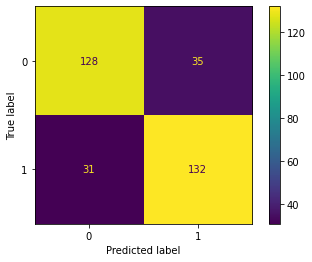

In [42]:
xgbc_predicted = cross_val_predict(xgbc_model,feat_train,targ_train,cv=10)
print(classification_report(targ_train, xgbc_predicted))
cm = confusion_matrix(targ_train, xgbc_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

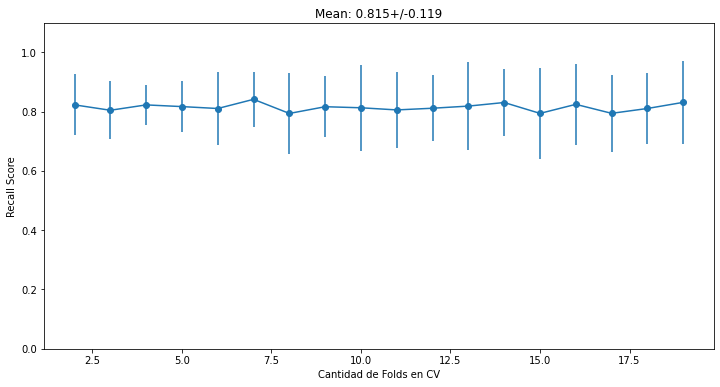

In [43]:
plt_eb(xgbc_model,20)

[(array([0.        , 0.21472393, 1.        ]), array([0.        , 0.80981595, 1.        ]), array([1.        , 0.80981595, 0.        ]), array([0.5       , 0.79041916, 1.        ]), 'XGBC')]


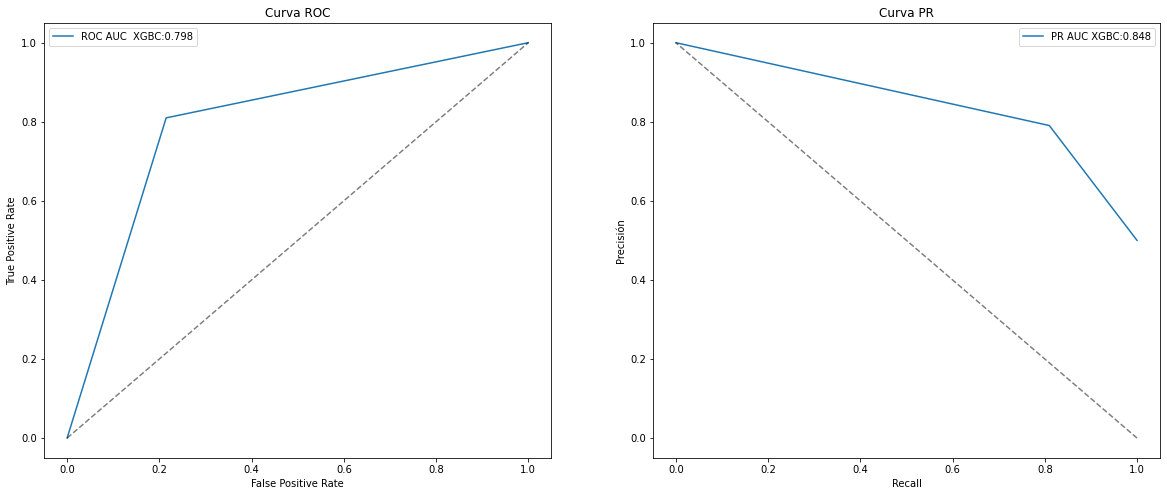

In [44]:
auc_data_xgbc = []
(ROC_fpr, ROC_tpr, PR_recalls, PR_precisions) = auc_curves_data(xgbc_model,feat_train,targ_train)
auc_data_xgbc.append((ROC_fpr, ROC_tpr, PR_recalls, PR_precisions,'XGBC'))

print(auc_data_xgbc)
auc_curves_plot(auc_data_xgbc)

---

### Voting Hard/Soft

In [45]:
vot_hard_model = VotingClassifier(
    estimators=[('lr', lr_model), ('tree', rf_model), ('svc', svc_model)],
    voting='hard')

vot_soft_model = VotingClassifier(
    estimators=[('lr', lr_model), ('tree', rf_model), ('svc', svc_model)],
    voting='soft')

vot_hard_model.fit(feat_train,targ_train)
vot_soft_model.fit(feat_train,targ_train)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=2.9470517025518097,
                                                 max_iter=40000)),
                             ('tree',
                              RandomForestClassifier(min_impurity_decrease=0.0002,
                                                     n_estimators=400)),
                             ('svc',
                              SVC(C=0.1487352107293511,
                                  gamma=1.1721022975334805,
                                  probability=True))],
                 voting='soft')

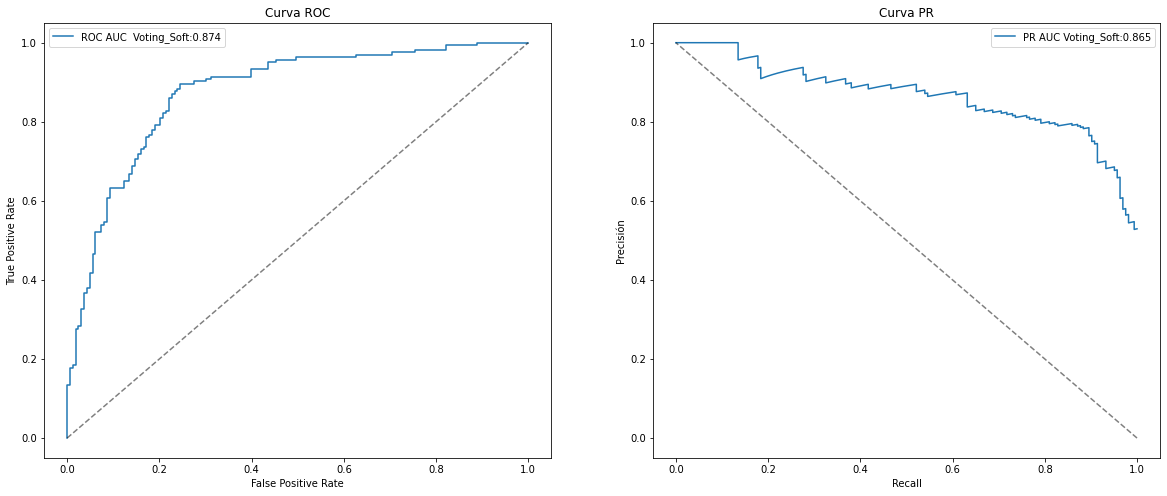

In [46]:
# auc_data_voting_hard = []
auc_data_voting_soft = []

# (ROC_fpr, ROC_tpr, PR_recalls, PR_precisions) = auc_curves_data(vot_hard_model,feat_train,targ_train)
# auc_data_voting_hard.append((ROC_fpr, ROC_tpr, PR_recalls, PR_precisions,'Voting_Hard'))

#Observación: predict_proba is not available when voting='hard'

(ROC_fpr, ROC_tpr, PR_recalls, PR_precisions) = auc_curves_data(vot_soft_model,feat_train,targ_train)
auc_data_voting_soft.append((ROC_fpr, ROC_tpr, PR_recalls, PR_precisions,'Voting_Soft'))

auc_curves_plot(auc_data_voting_soft)

## HARD

Cross Validation Score: 0.878 +/- 0.073
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       163
           1       0.76      0.84      0.80       163

    accuracy                           0.79       326
   macro avg       0.79      0.79      0.79       326
weighted avg       0.79      0.79      0.79       326



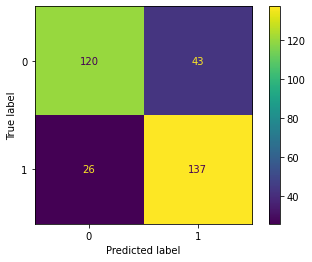

In [47]:
model_setup(vot_hard_model)

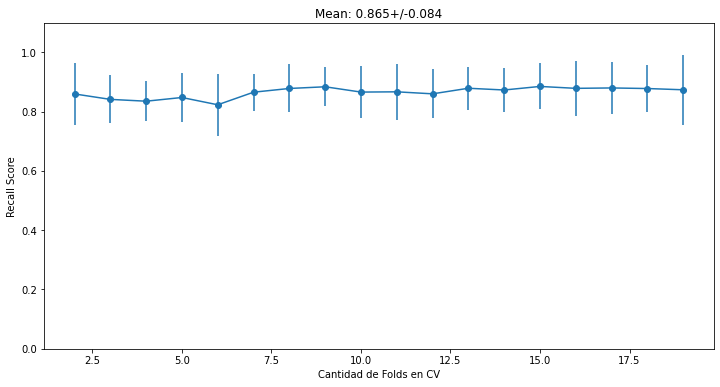

In [48]:
plt_eb(vot_hard_model,20)

## SOFT

Cross Validation Score: 0.836 +/- 0.100
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       163
           1       0.80      0.82      0.81       163

    accuracy                           0.80       326
   macro avg       0.80      0.80      0.80       326
weighted avg       0.80      0.80      0.80       326



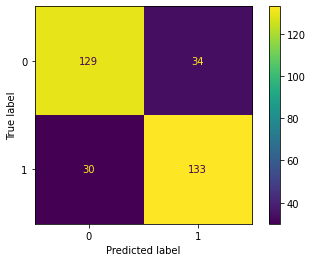

In [49]:
model_setup(vot_soft_model)

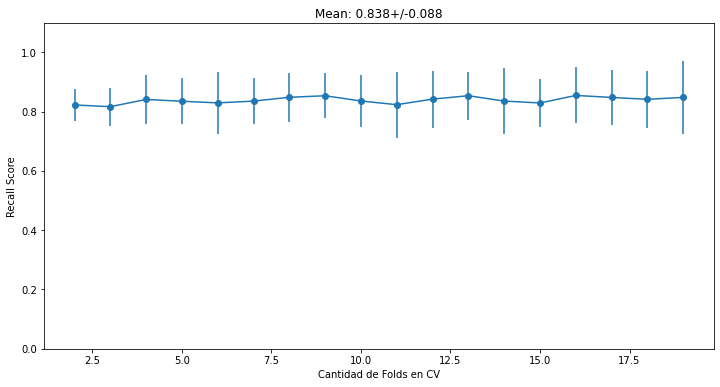

In [50]:
plt_eb(vot_soft_model,20)

---

# RED NEURONAL SIMPLE

In [51]:
keras.backend.clear_session()

In [52]:
input = keras.layers.Input(shape=[6,])
flatten = keras.layers.Flatten()(input)
hidden1 = keras.layers.Dense(100, activation="relu")(flatten)
dropout = keras.layers.Dropout(rate=0.2)(hidden1)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)
output = keras.layers.Dense(1, activation="sigmoid")(hidden2)

model = keras.models.Model(inputs=[input], outputs=[output])

2021-11-15 20:18:36.745876: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-15 20:18:36.747079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 20:18:36.747363: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.65GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2021-11-15 20:18:36.747546: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-15 20:18:36.747712: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic librar

In [53]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=[tf.keras.metrics.Recall()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
flatten (Flatten)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 100)               700       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,901
Trainable params: 10,901
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = model.fit(feat_train, targ_train, epochs=600, batch_size=32,
                    validation_split=0.2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)])

# esperamos 100 epocas para ver si hay mejoría. Si no hay mejoría, se vuelve a los valores óptimos y se frena el entrenamiento.

2021-11-15 20:18:36.875509: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-15 20:18:36.896930: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3997415000 Hz


Epoch 1/600
9/9 [==============================] - 1s 19ms/step - loss: 0.6709 - recall: 0.7835 - val_loss: 0.6774 - val_recall: 0.5909
Epoch 2/600
9/9 [==============================] - 0s 2ms/step - loss: 0.6116 - recall: 0.6186 - val_loss: 0.6799 - val_recall: 0.5606
Epoch 3/600
9/9 [==============================] - 0s 2ms/step - loss: 0.5732 - recall: 0.5258 - val_loss: 0.7125 - val_recall: 0.4545
Epoch 4/600
9/9 [==============================] - 0s 2ms/step - loss: 0.5468 - recall: 0.5155 - val_loss: 0.7725 - val_recall: 0.4545
Epoch 5/600
9/9 [==============================] - 0s 2ms/step - loss: 0.5287 - recall: 0.5155 - val_loss: 0.7531 - val_recall: 0.4697
Epoch 6/600
9/9 [==============================] - 0s 2ms/step - loss: 0.5143 - recall: 0.5464 - val_loss: 0.7708 - val_recall: 0.4848
Epoch 7/600
9/9 [==============================] - 0s 2ms/step - loss: 0.5044 - recall: 0.6082 - val_loss: 0.7390 - val_recall: 0.5606
Epoch 8/600
9/9 [==============================] - 0s 

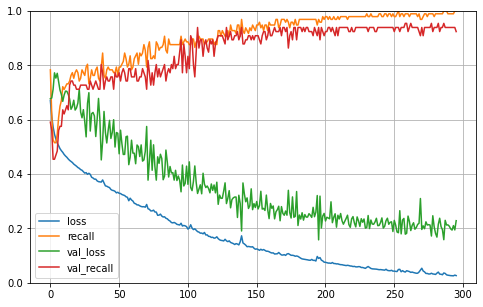

In [55]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [56]:
pd.DataFrame(history.history)

,loss,recall,val_loss,val_recall
0,0.670892,0.783505,0.677363,0.590909
1,0.611585,0.618557,0.679922,0.560606
2,0.573228,0.525773,0.712535,0.454545
3,0.546754,0.515464,0.772535,0.454545
4,0.528686,0.515464,0.753099,0.469697
...,...,...,...,...
291,0.026348,0.989691,0.198508,0.939394
292,0.026058,0.989691,0.193967,0.939394
293,0.025663,0.989691,0.210370,0.939394
294,0.028294,1.000000,0.194523,0.939394


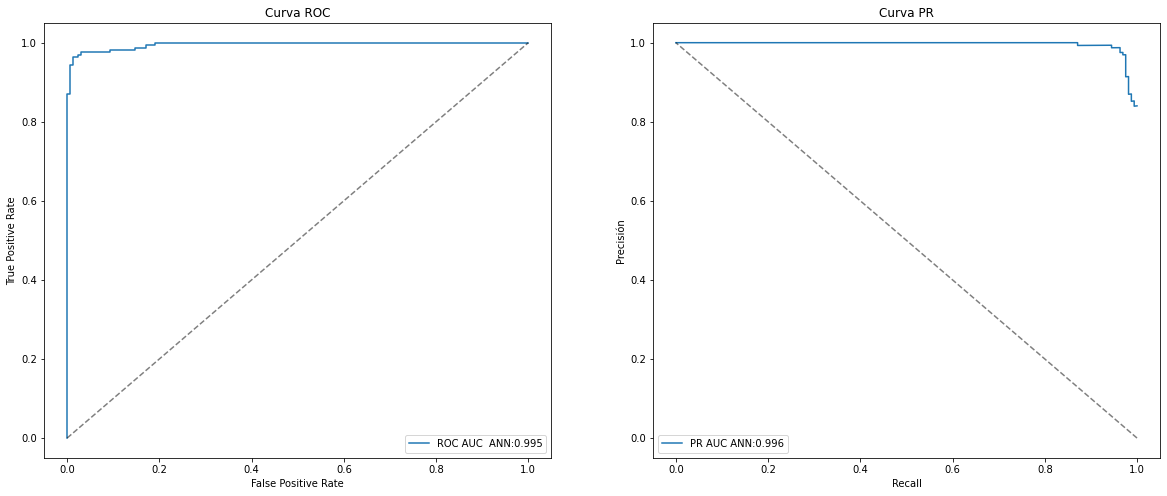

In [57]:
predicted_p = model.predict(feat_train)
precisions, recalls, thres = precision_recall_curve(targ_train, predicted_p)

fpr, tpr, thres = roc_curve(targ_train, predicted_p)
roc_auc = auc(fpr, tpr)
pr_auc = auc(recalls, precisions)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
# plt.subplot(1,2,1)
# plt.plot(fpr,tpr,label = "ROC AOC:{:.3f}".format(roc_auc))
# plt.plot([0,1],[0,1],'--k', alpha=0.5)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Curva ROC')
# plt.legend()
# plt.subplot(1,2,2)
# plt.plot(recalls,precisions,label = "PR AOC:{:.3f}".format(pr_auc))
# plt.plot([1,0],[0,1],'--k', alpha=0.5)
# plt.ylabel('Precisión')
# plt.xlabel('Recall')
# plt.title('Curva PR')
# plt.legend()

auc_data_ann = []
auc_data_ann.append((fpr, tpr, recalls, precisions, 'ANN'))
auc_curves_plot(auc_data_ann)


In [58]:
# yp = model.predict(feat_train)

# auc_data_ann = []
# (ROC_fpr, ROC_tpr, PR_recalls, PR_precisions) = auc_curves_data(svc_model,feat_train,targ_train)
# auc_data_svc.append((ROC_fpr, ROC_tpr, PR_recalls, PR_precisions, 'SVC'))
# auc_curves_plot(auc_data_svc)


In [59]:
# history.history.keys()
# plt.figure(figsize=(10, 6))
# plt.semilogy(history.history['loss'], label='Train Loss')
# plt.semilogy(history.history['val_loss'], label='Validation Loss')
# plt.legend(loc=0)

# k = 'accuracy'
# pd.DataFrame.from_dict(history.history).plot(y=['val_'+k, k], grid=True, figsize=(12,6))

(array([125.,  20.,   9.,   3.,   6.,   5.,   5.,   6.,  16., 131.]),
 array([2.7380327e-07, 1.0000018e-01, 2.0000009e-01, 2.9999998e-01,
        3.9999992e-01, 4.9999982e-01, 5.9999973e-01, 6.9999963e-01,
        7.9999954e-01, 8.9999944e-01, 9.9999934e-01], dtype=float32),
 <BarContainer object of 10 artists>)

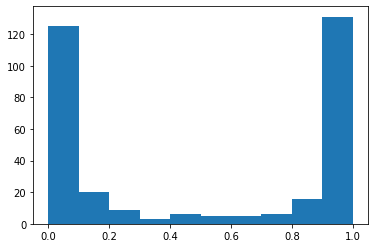

In [60]:
plt.hist(model.predict(feat_train))

(array([163.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 163.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

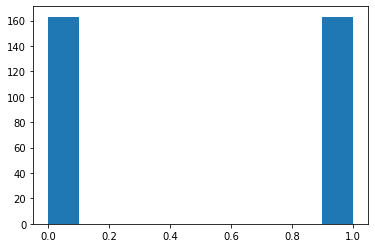

In [61]:
plt.hist(targ_train)

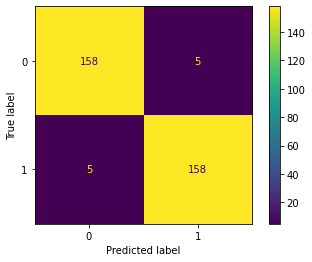

In [62]:
cm = confusion_matrix(targ_train, model.predict(feat_train)>0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

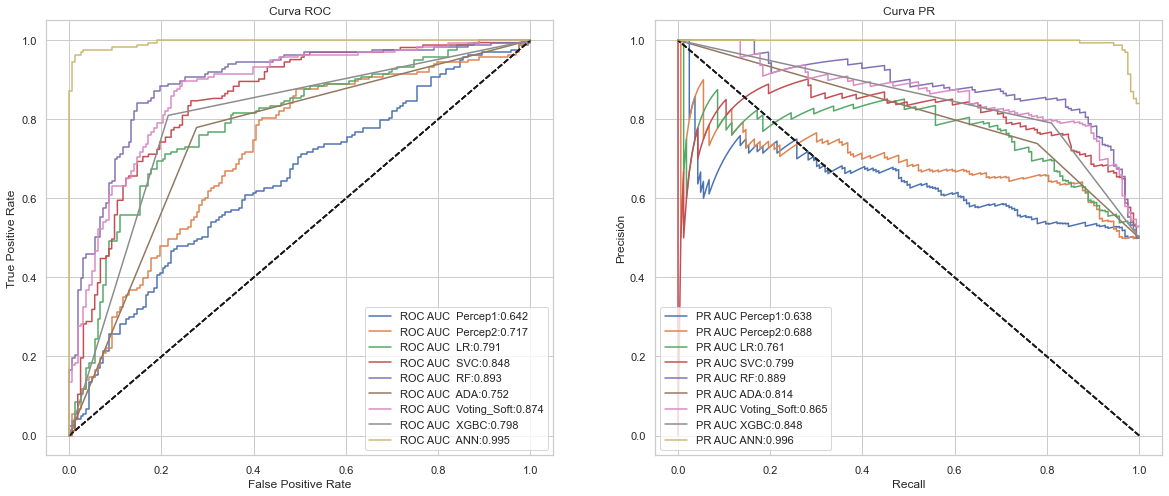

In [67]:
#Resumen final
AUC_data = []
AUC_data.append(auc_data_percep1[0])
AUC_data.append(auc_data_percep2[0])
AUC_data.append(auc_data_lr[0])
AUC_data.append(auc_data_svc[0])
AUC_data.append(auc_data_rf[0])
AUC_data.append(auc_data_ada[0])
AUC_data.append(auc_data_voting_soft[0])
AUC_data.append(auc_data_xgbc[0])
AUC_data.append(auc_data_ann[0])
auc_curves_plot(AUC_data)

[0]	validation_0-error:0.52459	validation_1-error:0.42683
[1]	validation_0-error:0.52459	validation_1-error:0.42683
[2]	validation_0-error:0.52459	validation_1-error:0.42683
[3]	validation_0-error:0.52459	validation_1-error:0.42683
[4]	validation_0-error:0.52459	validation_1-error:0.42683
[5]	validation_0-error:0.52459	validation_1-error:0.42683
[6]	validation_0-error:0.52459	validation_1-error:0.42683
[7]	validation_0-error:0.52459	validation_1-error:0.42683
[8]	validation_0-error:0.52459	validation_1-error:0.42683
[9]	validation_0-error:0.52459	validation_1-error:0.42683
[10]	validation_0-error:0.52459	validation_1-error:0.42683
[11]	validation_0-error:0.18443	validation_1-error:0.29268
[12]	validation_0-error:0.15574	validation_1-error:0.29268
[13]	validation_0-error:0.11885	validation_1-error:0.26829
[14]	validation_0-error:0.10656	validation_1-error:0.28049
[15]	validation_0-error:0.10656	validation_1-error:0.26829
[16]	validation_0-error:0.10246	validation_1-error:0.26829
[17]	va

<BarContainer object of 9 artists>

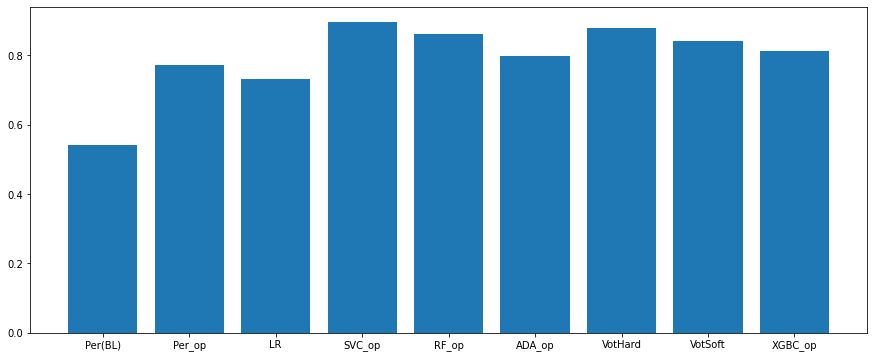

In [64]:
modelos = [
    Perceptron(fit_intercept=True, max_iter=40000),
    Perceptron(max_iter=40000,penalty="l2",random_state=420,alpha=0.0012689610031679235,eta0=0.041753189365604),
    LogisticRegression(dual=False, max_iter=40000,C=2.9470517025518097),
    SVC(probability=True,gamma=1.1721022975334805,C=0.1487352107293511),
    RandomForestClassifier(n_estimators=50),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),learning_rate=2e-2),
    VotingClassifier(estimators=[('lr', LogisticRegression(dual=False, max_iter=40000,C=2.9470517025518097)), ('tree', RandomForestClassifier(n_estimators=400,min_impurity_decrease=2e-4)), ('svc', SVC(probability=True,gamma=1.1721022975334805,C=0.1487352107293511))],voting='hard'),
    VotingClassifier(estimators=[('lr', LogisticRegression(dual=False, max_iter=40000,C=2.9470517025518097)), ('tree', RandomForestClassifier(n_estimators=400,min_impurity_decrease=2e-4)), ('svc', SVC(probability=True,gamma=1.1721022975334805,C=0.1487352107293511))],voting='soft')
]
scores = []
scores_mean = []

for model in modelos:
    model.fit(feat_train,targ_train)
    scoring = cross_val_score(model, feat_train, targ_train,cv=10, scoring=score_metric)
    scores.append(scoring)
    scores_mean.append(np.mean(scoring))

xgbc_model = XGBClassifier(use_label_encoder=False,objective='binary:hinge',learning_rate=0.05,n_estimators=500)
xgbc_model.fit(feat_train_2,targ_train_2,eval_set=[(feat_train_2, targ_train_2), (feat_val, targ_val)],eval_metric="error",early_stopping_rounds=20,verbose=True)
xgbc_scoring = cross_val_score(xgbc_model, feat_train, targ_train,cv=10, scoring=score_metric)

scores.append(xgbc_scoring )
scores_mean.append(np.mean(xgbc_scoring ))

print(scores_mean)

scores = pd.DataFrame(np.array(scores).T)
scores.columns = ["Per(BL)","Per_op","LR","SVC_op","RF_op","ADA_op","VotHard","VotSoft", "XGBC_op"]

# meaned_scores = [0.657,0.711,0.801,0.877,0.865,0.781,0.871,0.862]

plt.figure(figsize=(15,6))
plt.bar(scores.columns,scores_mean)

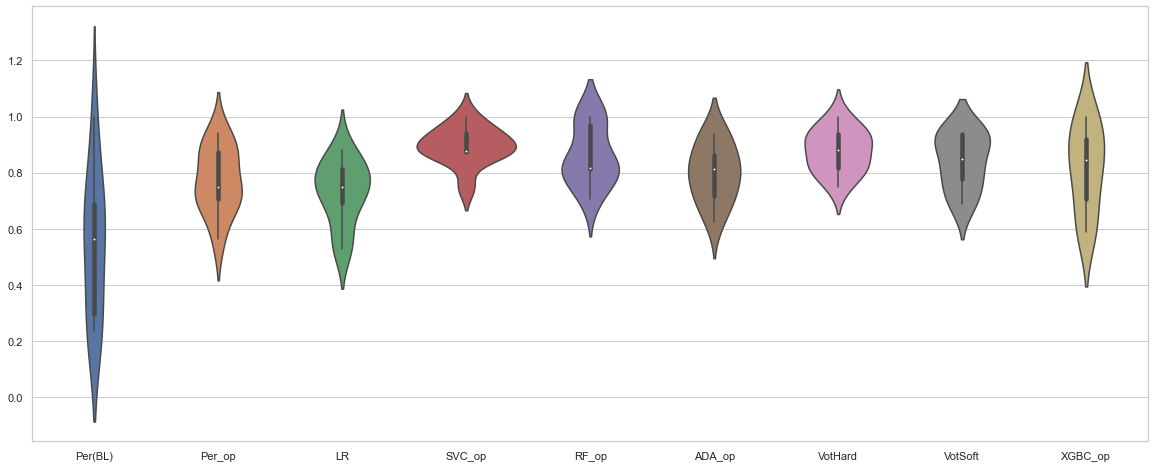

In [65]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20,8))
sns.violinplot(data=scores)
plt.show()

In [66]:
#Evaluando con el conjunto de Testing

#datos de testing (20% del dataset original)
df_test = pd.read_csv(r"DS_G3_HeartFailure_FULL_test.csv",index_col=0)  
df_test.shape


df_test_cleaned = df_test.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
# NOS QUEDAMOS CON AGE, CREATININE_PHOSPHOKINASE, EJECTION_FRACTION, PLATELETS, SERUM_CREATININE, SERUM_SODIUM Y DEATH_EVENT

feat_test, targ_test = df_test_cleaned.drop(["DEATH_EVENT"],axis=1),df_test_cleaned["DEATH_EVENT"]
print(feat_test.shape)
print(targ_test.shape)

scaler = StandardScaler()
feat_test = scaler.transform(feat_test)  #sólo transform, no uso el fit

(60, 6)
(60,)


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
#Evalúo los modelos con el testing set

#ANN
model.evaluate(feat_test, targ_test)